<a href="https://colab.research.google.com/github/Aman-k-s/Meat-Spoilage-Detection/blob/main/try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure, filters
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN
from sklearn.manifold import TSNE
import seaborn as sns
# Load dataset
base_path = "dataset"
classes = ["DI", "Bacteria"]

data = []
labels = []
times = []

# Loop through classes and time folders
for cls in classes:
    class_path = os.path.join(base_path, cls)
    for time_folder in os.listdir(class_path):
        time_path = os.path.join(class_path, time_folder)
        if not os.path.isdir(time_path): continue

        time_value = int(time_folder)
        for img_file in os.listdir(time_path):
            img_path = os.path.join(time_path, img_file)

            # Load image (grayscale)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))  # resize for uniformity

            # 2 Feature Extraction

            # Intensity features
            mean_intensity = np.mean(img)
            var_intensity = np.var(img)

            # Thresholding (Otsu)
            thresh_val = filters.threshold_otsu(img)
            binary = img > thresh_val
            area_white = np.sum(binary) / binary.size

            # Histogram features
            hist, _ = np.histogram(img, bins=32, range=(0, 256))
            hist = hist / hist.sum()
            hist_entropy = -np.sum(hist * np.log2(hist + 1e-7))

            # Histogram Equalization (contrast measure)
            eq_img = exposure.equalize_hist(img)
            contrast = eq_img.std()

            # Edge features (Canny)
            edges = cv2.Canny(img, 30, 90)
            edge_density = np.sum(edges > 0) / edges.size

            # Collect features
            features = [mean_intensity, var_intensity, area_white, hist_entropy, contrast, edge_density]
            features.extend(hist)

            data.append(features)
            labels.append(cls)
            times.append(time_value)

# Convert to DataFrame
feature_names = ["mean_intensity", "var_intensity", "area_white",
                 "hist_entropy", "contrast", "edge_density"] + [f"hist_bin{i}" for i in range(32)]

df = pd.DataFrame(data, columns=feature_names)
df["label"] = labels
df["time"] = times

# Save CSV
df.to_csv("features_dataset.csv", index=False)
print("features_dataset.csv")
print(df.head())


features_dataset.csv
   mean_intensity  var_intensity  area_white  hist_entropy  contrast  \
0        4.019043      42.359623    0.083435      0.716861  0.053120   
1        3.327332      23.866670    0.081116      0.539290  0.049149   
2        4.223328      65.591055    0.086426      0.745338  0.053074   
3        4.301453      49.450447    0.101440      0.786761  0.057783   
4        3.084290      18.640783    0.061096      0.440322  0.051172   

   edge_density  hist_bin0  hist_bin1  hist_bin2  hist_bin3  ...  hist_bin24  \
0      0.025513   0.884827   0.060120   0.038025   0.009277  ...         0.0   
1      0.004150   0.910156   0.058533   0.028748   0.001221  ...         0.0   
2      0.015991   0.880981   0.051270   0.045654   0.015625  ...         0.0   
3      0.018433   0.865784   0.061584   0.058105   0.008484  ...         0.0   
4      0.011230   0.928528   0.059814   0.007385   0.001587  ...         0.0   

   hist_bin25  hist_bin26  hist_bin27  hist_bin28  hist_bin29  hi

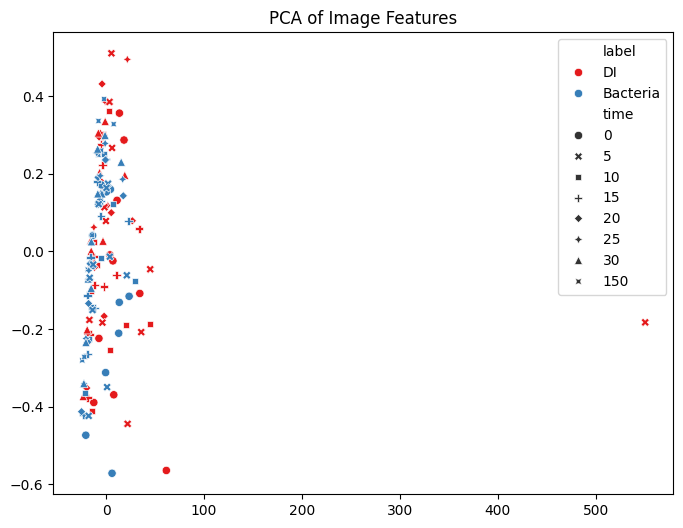

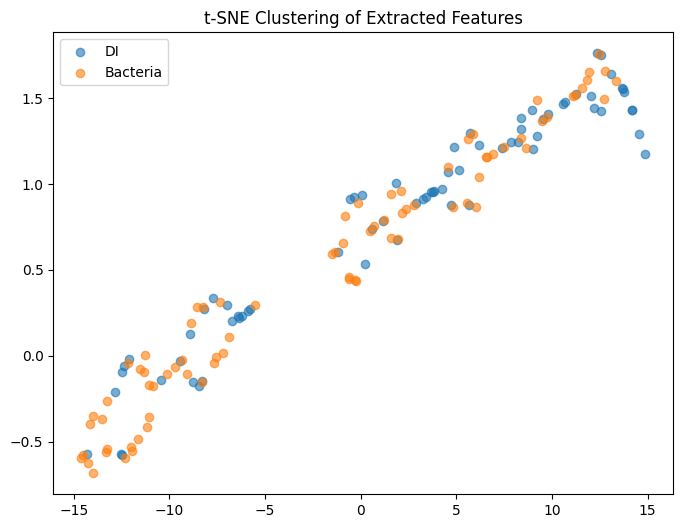

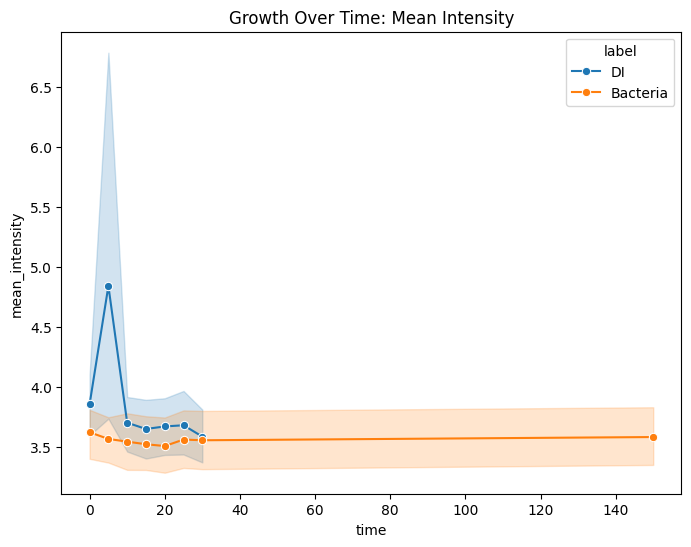

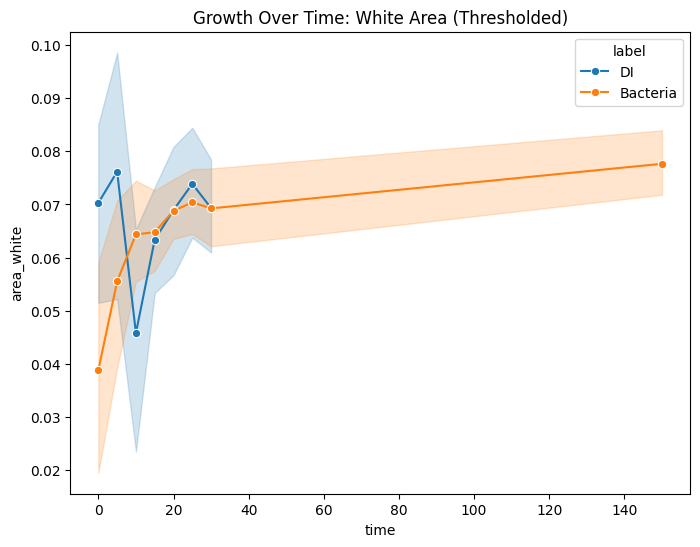

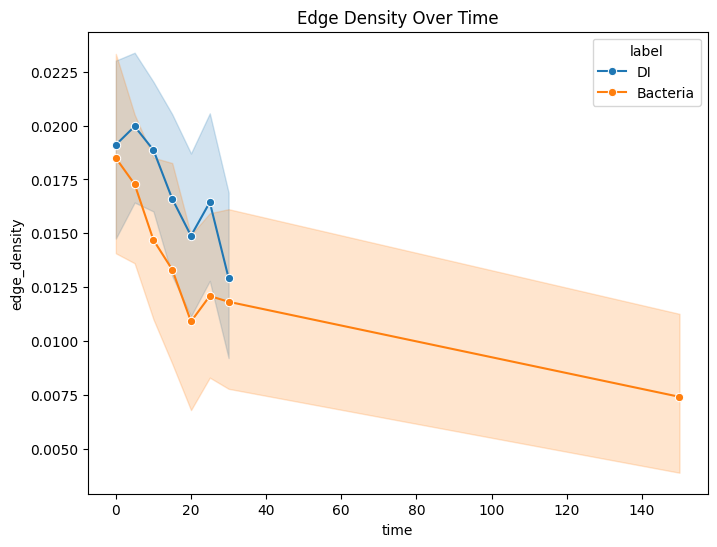

In [2]:
# PCA for 2D visualization
X = df.drop(columns=["label","time"]).values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], style=df["time"], palette="Set1")
plt.title("PCA of Image Features")
plt.show()

# TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X)

df["tsne-2d-one"] = tsne_results[:,0]
df["tsne-2d-two"] = tsne_results[:,1]

plt.figure(figsize=(8,6))
for label in df["label"].unique():
    subset = df[df["label"] == label]
    plt.scatter(subset["tsne-2d-one"], subset["tsne-2d-two"], label=label, alpha=0.6)

plt.title("t-SNE Clustering of Extracted Features")
plt.legend()
plt.show()


# Growth over time (mean intensity / area)
plt.figure(figsize=(8,6))
sns.lineplot(x="time", y="mean_intensity", hue="label", data=df, marker="o")
plt.title("Growth Over Time: Mean Intensity")
plt.show()

plt.figure(figsize=(8,6))
sns.lineplot(x="time", y="area_white", hue="label", data=df, marker="o")
plt.title("Growth Over Time: White Area (Thresholded)")
plt.show()

#Edge Density comparison
plt.figure(figsize=(8,6))
sns.lineplot(x="time", y="edge_density", hue="label", data=df, marker="o")
plt.title("Edge Density Over Time")
plt.show()



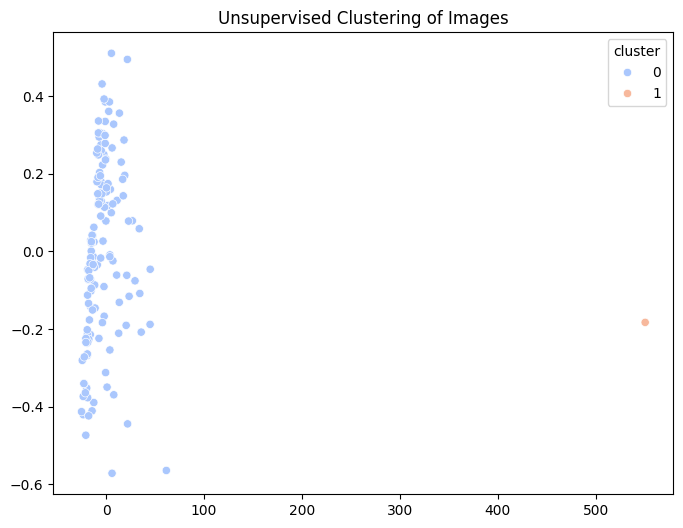

In [4]:
# KMeans clustering
kmeans = KMeans(n_clusters=2)
df["cluster"] = kmeans.fit_predict(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster"], palette="coolwarm")
plt.title("Unsupervised Clustering of Images")
plt.show()


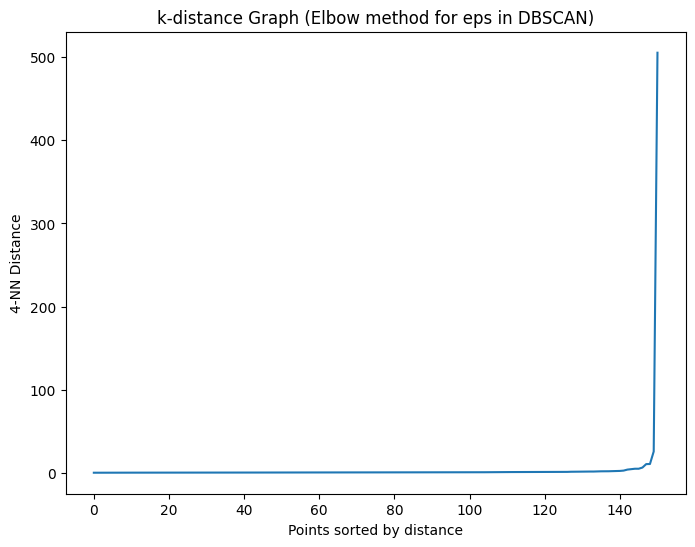

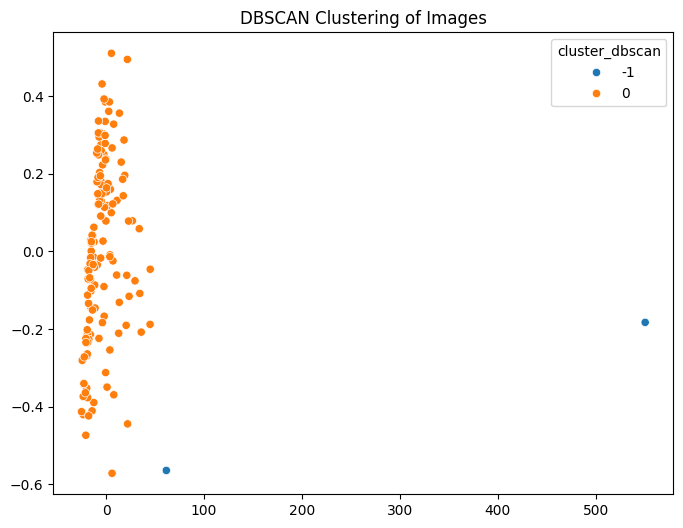

In [5]:
from sklearn.neighbors import NearestNeighbors
# k-distance graph for DBSCAN
min_samples = 4
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Sort distances for elbow plot
distances = np.sort(distances[:, min_samples-1])  # take the k-th NN distance
plt.figure(figsize=(8,6))
plt.plot(distances)
plt.title("k-distance Graph (Elbow method for eps in DBSCAN)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN Distance")
plt.show()

# DBScan
dbscan = DBSCAN(eps=12, min_samples=min_samples)
df["cluster_dbscan"] = dbscan.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster_dbscan"], palette="tab10")
plt.title("DBSCAN Clustering of Images")
plt.show()

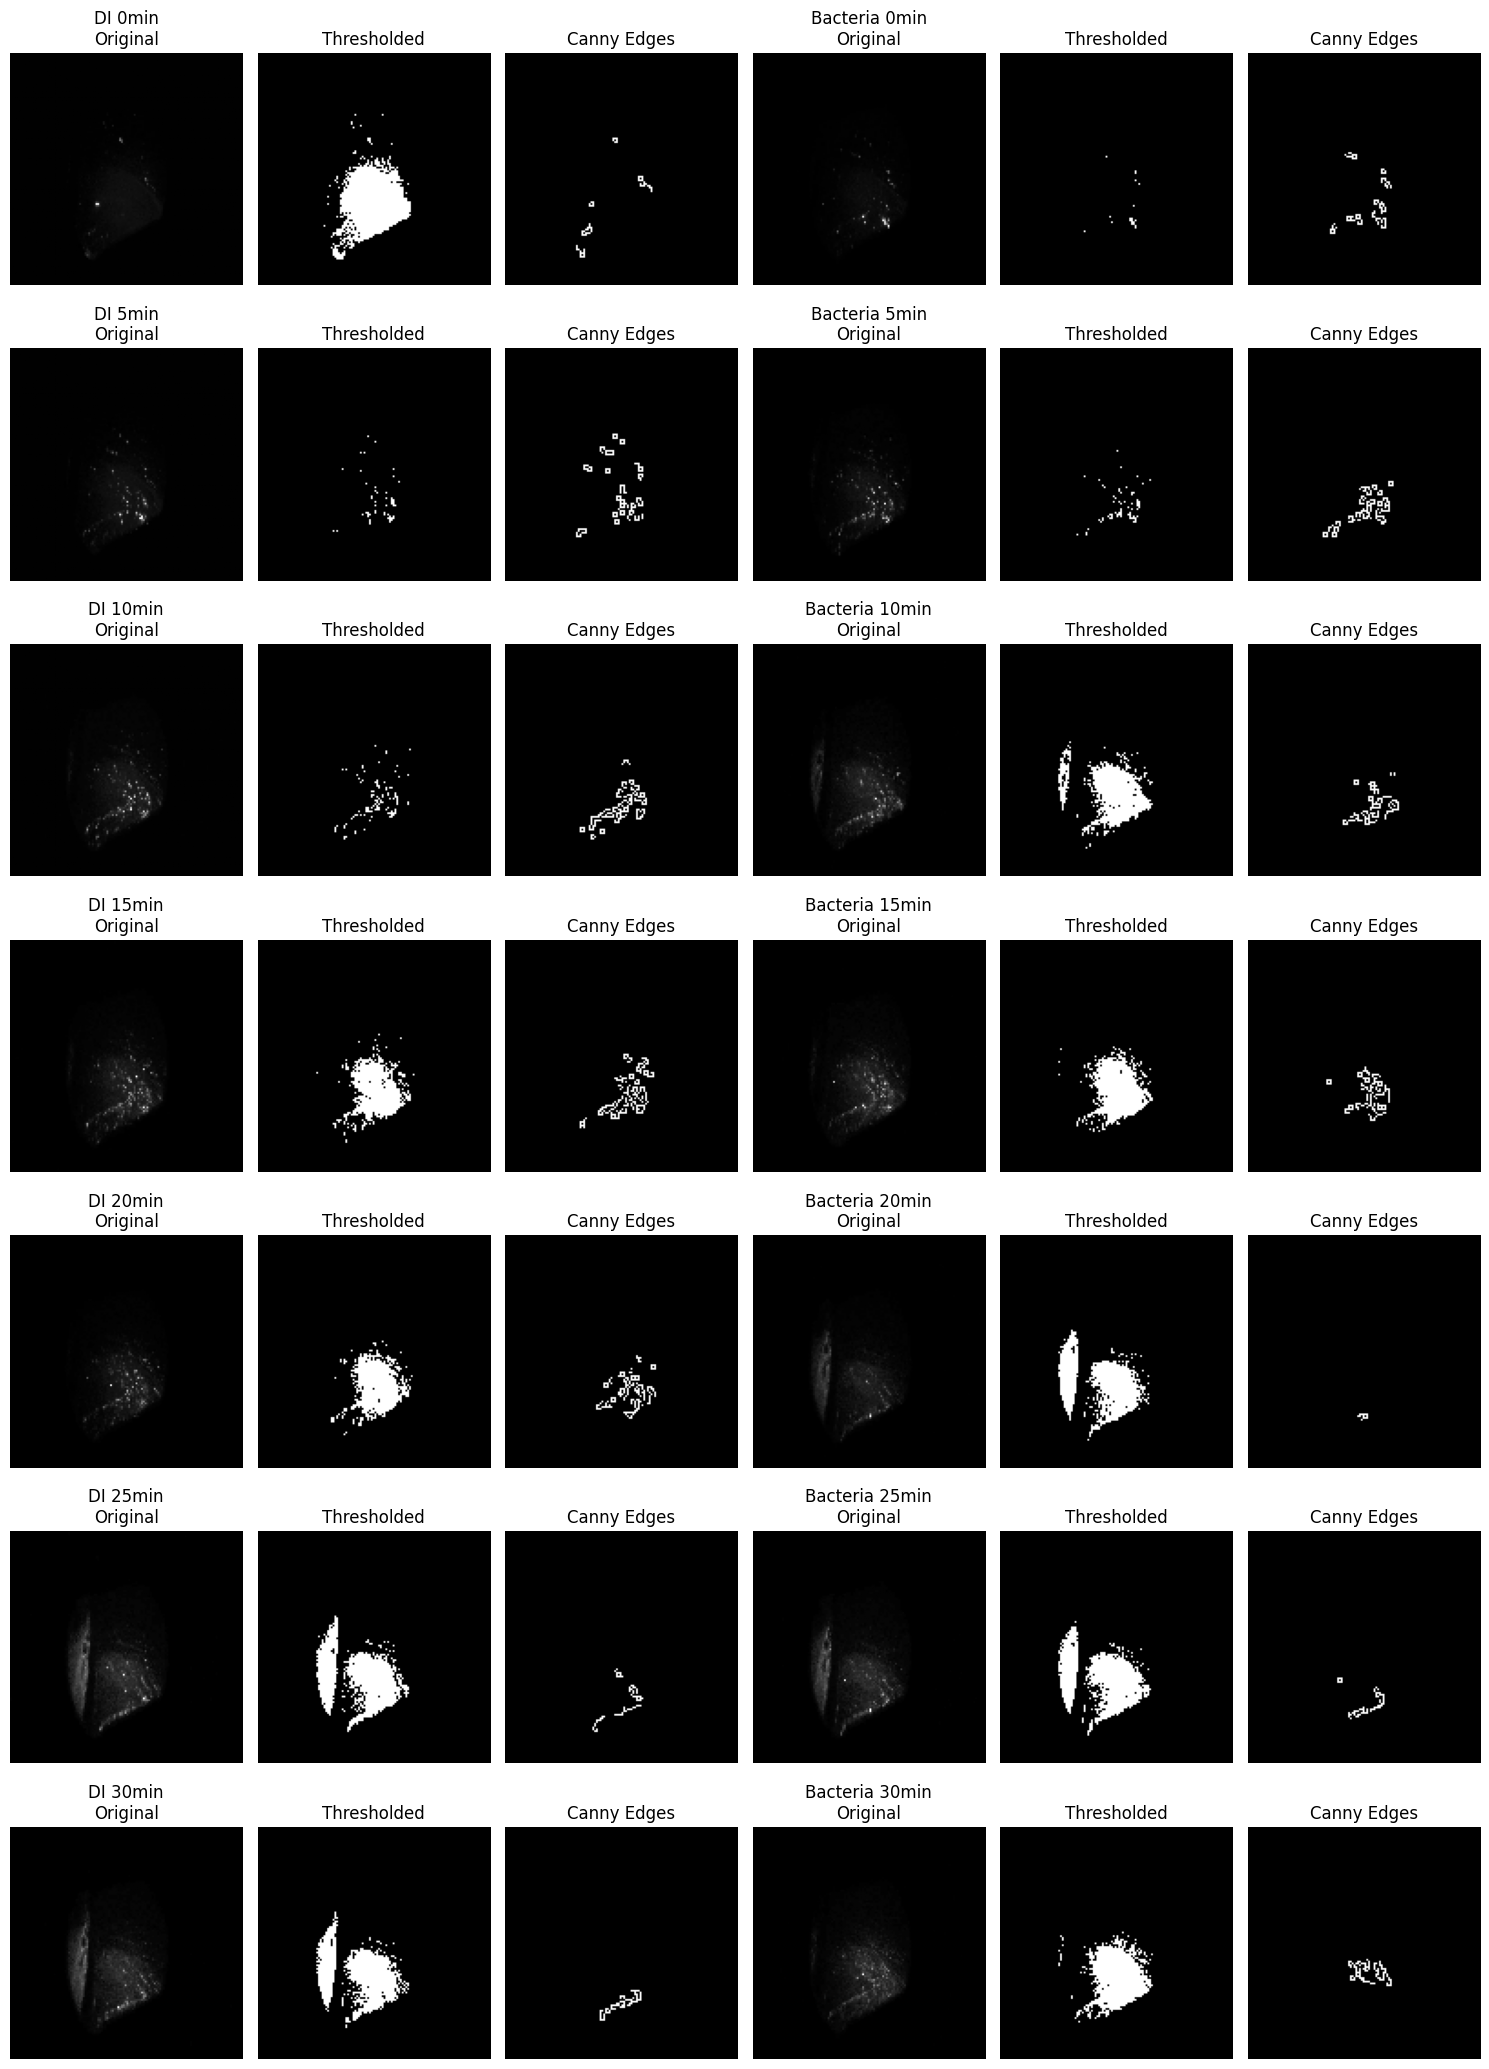

In [6]:
time_points = sorted([int(t) for t in os.listdir(os.path.join(base_path, "DI")) if t.isdigit()])

plt.figure(figsize=(15, len(time_points)*3))

for idx, t in enumerate(time_points):
    for j, cls in enumerate(classes):  # "DI" and "Bacteria"
        time_path = os.path.join(base_path, cls, str(t))
        img_files = os.listdir(time_path)
        if not img_files:
            continue
        # take image
        img_path = os.path.join(time_path, img_files[1])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))

        # Thresholding
        thresh_val = filters.threshold_otsu(img)
        binary = img > thresh_val

        # Edge detection
        edges = cv2.Canny(img, 30, 150)

        # Plot Original
        plt.subplot(len(time_points), len(classes)*3, idx*len(classes)*3 + j*3 + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{cls} {t}min\nOriginal")
        plt.axis("off")

        # Plot Thresholded
        plt.subplot(len(time_points), len(classes)*3, idx*len(classes)*3 + j*3 + 2)
        plt.imshow(binary, cmap="gray")
        plt.title("Thresholded")
        plt.axis("off")

        # Plot Edges
        plt.subplot(len(time_points), len(classes)*3, idx*len(classes)*3 + j*3 + 3)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edges")
        plt.axis("off")

plt.tight_layout()
plt.show()
